In [21]:
include("hmat.jl")
include("test_Merton_kernel.jl")
include("tools.jl")
using BenchmarkTools
using Polynomials
@pyimport matplotlib2tikz as mpl

In [2]:
n = 6
N = 2^n
x = LinRange(-1.0, 1.0, N)
h = x[2]-x[1]
X = zeros(N^2, 2)
for i = 1:N
    for j = 1:N
        X[i+(j-1)*N, 1] = x[i]
        X[i+(j-1)*N, 2] = x[j]
    end
end
c = construct_cluster(X, 64)
# plot(c;showit=true)

Cluster
  X: Array{Float64}((4096, 2)) [0.777778 0.269841; 0.809524 0.269841; … ; -0.301587 -0.777778; -0.269841 -0.777778]
  P: Array{Int64}((4096,)) [2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2681, 2682  …  407, 408, 465, 466, 467, 468, 469, 470, 471, 472]
  left: Cluster
  right: Cluster
  m: Int64 2048
  n: Int64 2048
  N: Int64 4096
  isleaf: Bool false
  s: Int64 1
  e: Int64 4096


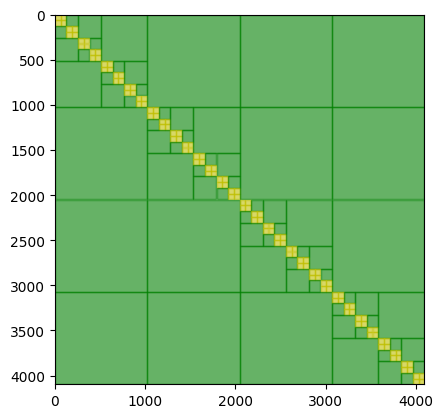

  2.281265 seconds (23.25 M allocations: 659.483 MiB, 14.03% gc time)
Matrix Error = 0.008137494186098715
Matvec Error = 0.0022224781689532645
Matrix Error = 4.100526170873573e-6
Matvec Error = 4.796240653494536e-6
Matrix Error = 4.100526170873573e-6
Matvec Error = 4.760984191606572e-6


In [140]:
NT = 100
Δt = 1/NT
C = π/5.0

# both works
f, αs, βs = Merton_Kernel2D(sqrt(5.0), 10)
@time H = construct_hmat_from_expansion(f, αs, βs, c, 64, -1; verbose=false)

# @time H = construct_hmat(f, c, 64, 15 ,1e-6, -1, "svd"; verbose=false)
matshow(H)
H1 = copy(H)
H2 = copy(H)


haxpy!(0.5*h^2, H1, -C/2+1/Δt)
haxpy!(-0.5*h^2, H2, C/2+1/Δt)

A = kernel_full(f, c.X, c.X)
verify_matrix_error(H, A)
verify_matvec_error(H, A)
A1 = 0.5*h^2*A+(-C/2+1/Δt)*diagm(0=>ones(size(A,1))) # right
A2 = -0.5*h^2*A+(C/2+1/Δt)*diagm(0=>ones(size(A,1))) # left 
verify_matrix_error(H1, A1)
verify_matvec_error(H1, A1)
verify_matrix_error(H2, A2)
verify_matvec_error(H2, A2)


In [103]:
info(H)

Dense matrix = 32, Low Rank Matrix = 608, Levels = 6, Goodness = 769

(32, 608, 6, 0.18768310546875)

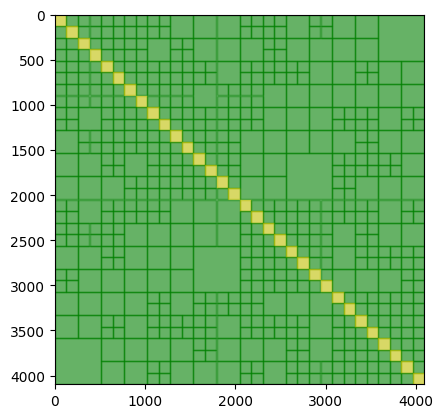

In [101]:
matshow(H)

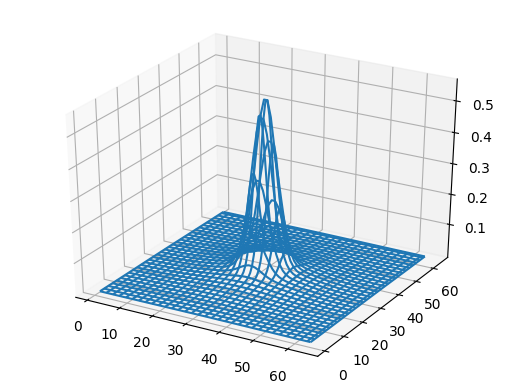

PyObject <mpl_toolkits.mplot3d.art3d.Line3DCollection object at 0x7f2216ad48d0>

In [63]:
# iteration
U1 = zeros(size(c.X,1), NT+1)
U1[:,1] = exp.(-50 * (c.X[:,1].^2+c.X[:,2].^2))

F = lu(A2)
for i = 1:NT
    U1[:,i+1] = F\(A1*U1[:,i])
end

u1 = U1[:,end]
p = inverse_permutation(c.P)
u1 = reshape(u1[p], N, N)
mesh(u1)

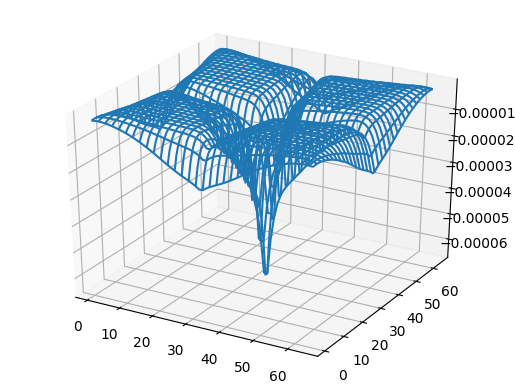

  1.082742 seconds (118.10 k allocations: 360.518 MiB, 34.89% gc time)


PyObject <mpl_toolkits.mplot3d.art3d.Line3DCollection object at 0x7f2215b7be48>

In [153]:
U = zeros(size(c.X,1), NT+1)
U[:,1] = exp.(-50 * (c.X[:,1].^2+c.X[:,2].^2))

HH = copy(H2)
@time lu!(HH,1e-2);
# verify_lu_error(H2, HH, A2)
for i = 1:NT
    U[:,i+1] = pygmres(H2, H1*U[:,i], HH)
end

u = U[:,end]
p = inverse_permutation(c.P)
u = reshape(u[p], N, N)
mesh(u-u1)

In [149]:
x1, _ = pygmres_with_call_back(H2, H1*U[:,1], HH, true)
x2 = A2\(H1*U[:,1])
rel_error(x1,x2)

Iteration 0, Error = 2.8120400724810392e-8
Iteration 1, Error = 9.851044772190978e-14


3.67128380344044e-7

## Efficiency Test

In [7]:
function benchmark1(n=5)
    NT = 100
    Δt = 1/NT
    C = π/5.0

    N = 2^n
    x = LinRange(-1.0, 1.0, N)
    h = x[2]-x[1]
    X = zeros(N^2, 2)
    for i = 1:N
        for j = 1:N
            X[i+(j-1)*N, 1] = x[i]
            X[i+(j-1)*N, 2] = x[j]
        end
    end
    c = construct_cluster(X, 64)

    # both works
    f, αs, βs = Merton_Kernel2D(sqrt(5.0), 10)
    t1 = @timed H = construct_hmat_from_expansion(f, αs, βs, c, 64, -1; verbose=false)

    # @time H = construct_hmat(f, c, 64, 15 ,1e-6, -1, "svd"; verbose=false)
    H1 = copy(H)
    H2 = copy(H)

    haxpy!(0.5*h^2, H1, -C/2+1/Δt)
    haxpy!(-0.5*h^2, H2, C/2+1/Δt)
    info(H2)

    x = rand(N^2)
    y = rand(N^2)
    x1 = rand(N^2)
    t2 = @timed begin
        for i = 1:10
            y = H1*x
        end
    end

    HH = copy(H2)
    GC.enable(false)
    t3 = @timed lu!(HH, 1e-2)
    GC.enable(true)
    GC.gc()

    t4 = @timed begin
        for i = 1:10
            x1 = HH\y
        end
    end
    x2, err2 = pygmres_with_call_back(H2, y, nothing, false)
    x3, err3 = pygmres_with_call_back(H2, y, HH, false)
#     println("Error = $(rel_error(x, x1)), Iter = $(length(err2))")
#     println("Error = $(rel_error(x, x2)), Iter = $(length(err3))")

    (t1[2], t2[2]/10, t3[2], t4[2]/10), t1[3]
end

benchmark1 (generic function with 2 methods)

In [8]:
benchmark1()
T = []
S = []
for n = 5:10
    t, s = benchmark1(n)
    push!(T, t)
    push!(S, s)
    println(t, s)
end

Dense matrix = 32, Low Rank Matrix = 20, Levels = 5, Goodness = 928
Dense matrix = 16, Low Rank Matrix = 0, Levels = 3, Goodness = 256
(0.011541026, 6.75159e-5, 0.00385728, 0.0016703638999999999)19437680
Dense matrix = 32, Low Rank Matrix = 20, Levels = 5, Goodness = 928
(0.279334639, 0.0007449968, 0.232011202, 0.00119636)120654656
Dense matrix = 128, Low Rank Matrix = 68, Levels = 7, Goodness = 1328
(1.709158927, 0.0048214474, 1.085102725, 0.0067007124)659449744
Dense matrix = 512, Low Rank Matrix = 260, Levels = 9, Goodness = 1728
(9.160934275, 0.0404143523, 4.410872722, 0.0265675788)3394819600
Dense matrix = 2133, Low Rank Matrix = 1066, Levels = 12, Goodness = 2447
(48.77634445, 0.23252465039999998, 22.965052433, 0.10359730810000001)18879384224
Dense matrix = 9860, Low Rank Matrix = 4460, Levels = 14, Goodness = 3404
(272.110659505, 1.327147896, 95.64710674, 0.3101372585)103887541344
Dense matrix = 37746, Low Rank Matrix = 17458, Levels = 16, Goodness = 3883
(1390.282231436, 6.6575

In [11]:
function benchmark2(n=5)
    NT = 100
    Δt = 1/NT
    C = π/5.0

    N = 2^n
    x = LinRange(-1.0, 1.0, N)
    h = x[2]-x[1]
    X = zeros(N^2, 2)
    for i = 1:N
        for j = 1:N
            X[i+(j-1)*N, 1] = x[i]
            X[i+(j-1)*N, 2] = x[j]
        end
    end
    c = construct_cluster(X, 64)
    
    f, αs, βs = Merton_Kernel2D(sqrt(5.0), 10)
    t1 = @timed A = kernel_full(f, c.X, c.X)
    A1 = 0.5*h^2*A+(-C/2+1/Δt)*diagm(0=>ones(size(A,1))) # right
    A2 = -0.5*h^2*A+(C/2+1/Δt)*diagm(0=>ones(size(A,1))) # left 

    x = rand(N^2)
    y = rand(N^2)
    x1 = rand(N^2)
    t2 = @timed begin
        for i = 1:10
            y = A2*x
        end
    end

    t3 = @timed F = lu(A2)

    t4 = @timed begin
        for i = 1:10
            x1 = F\y
        end
    end

    (t1[2], t2[2]/10, t3[2], t4[2]/10), t1[3]
end

benchmark2 (generic function with 2 methods)

In [ ]:
benchmark2()
T1 = []
S1 = []
for n = 5:9
    t, s = benchmark2(n)
    push!(T1, t)
    push!(S1, s)
    println(t, s)
end

(0.505909355, 0.0001598307, 0.045030348, 0.0004179065)310379312
(9.482454493, 0.1495839336, 0.676154922, 0.0173444921)4966058320
(82.612928767, 0.0454957939, 13.478212619, 0.2419952142)79456900208


In [18]:
T

7-element Array{Any,1}:
 (0.011541026, 6.75159e-5, 0.00385728, 0.0016703638999999999)         
 (0.279334639, 0.0007449968, 0.232011202, 0.00119636)                 
 (1.709158927, 0.0048214474, 1.085102725, 0.0067007124)               
 (9.160934275, 0.0404143523, 4.410872722, 0.0265675788)               
 (48.77634445, 0.23252465039999998, 22.965052433, 0.10359730810000001)
 (272.110659505, 1.327147896, 95.64710674, 0.3101372585)              
 (1390.282231436, 6.657581154000001, 452.012639607, 1.2069433433)     

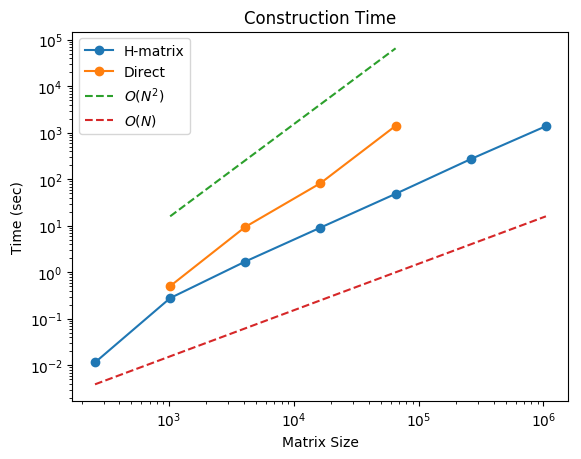

In [61]:
loglog(4 .^(4:10), [x[1] for x in T], "o-", label="H-matrix")
loglog(4 .^(5:8), [x[1] for x in T1], "o-", label="Direct")


r = polyfit(log.(4 .^(4:10)), log.([x[1] for x in T]), 1)
r[1] = 2.0
loglog(4 .^(5:8), exp.(r(log.(4 .^(5:8)))), "--", label=L"O(N^2)")
r[1] = 1.0
loglog(4 .^(4:10), exp.(r(log.(4 .^(4:10)))), "--", label=L"O(N)")

xlabel("Matrix Size")
ylabel("Time (sec)")
title("Construction Time")
legend()
mpl.save("latex/figures/gauss2d_construct.tex")

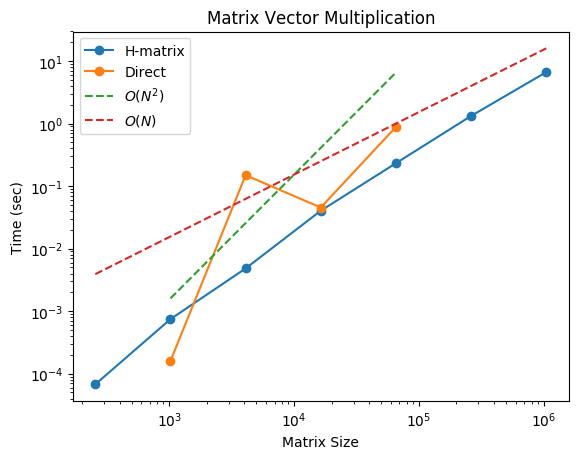

In [62]:
loglog(4 .^(4:10), [x[2] for x in T], "o-", label="H-matrix")
loglog(4 .^(5:8), [x[2] for x in T1], "o-", label="Direct")

r = polyfit(log.(4 .^(4:10)), log.([x[1] for x in T]), 1)
r[1] = 2.0
loglog(4 .^(5:8), 1e-4*exp.(r(log.(4 .^(5:8)))), "--", label=L"O(N^2)")
r[1] = 1.0
loglog(4 .^(4:10), exp.(r(log.(4 .^(4:10)))), "--", label=L"O(N)")


xlabel("Matrix Size")
ylabel("Time (sec)")
title("Matrix Vector Multiplication")
legend()
mpl.save("latex/figures/gauss2d_matvec.tex")

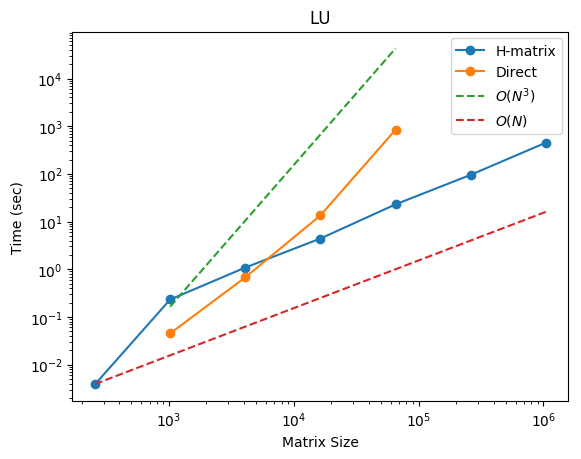

In [64]:
loglog(4 .^(4:10), [x[3] for x in T], "o-", label="H-matrix")
loglog(4 .^(5:8), [x[3] for x in T1], "o-", label="Direct")

r = polyfit(log.(4 .^(4:10)), log.([x[1] for x in T]), 1)
r[1] = 3.0
loglog(4 .^(5:8), 1e-5*exp.(r(log.(4 .^(5:8)))), "--", label=L"O(N^3)")
r[1] = 1.0
loglog(4 .^(4:10), exp.(r(log.(4 .^(4:10)))), "--", label=L"O(N)")


xlabel("Matrix Size")
ylabel("Time (sec)")
title("LU")
legend()
mpl.save("latex/figures/gauss2d_lu.tex")

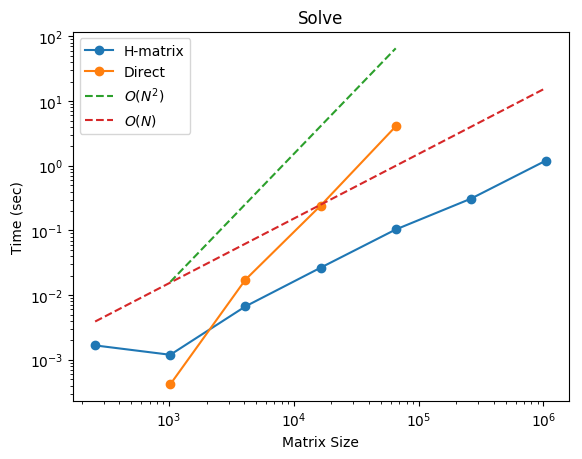

In [65]:
loglog(4 .^(4:10), [x[4] for x in T], "o-", label="H-matrix")
loglog(4 .^(5:8), [x[4] for x in T1], "o-", label="Direct")

r = polyfit(log.(4 .^(4:10)), log.([x[1] for x in T]), 1)
r[1] = 2.0
loglog(4 .^(5:8), 1e-3*exp.(r(log.(4 .^(5:8)))), "--", label=L"O(N^2)")
r[1] = 1.0
loglog(4 .^(4:10), exp.(r(log.(4 .^(4:10)))), "--", label=L"O(N)")


xlabel("Matrix Size")
ylabel("Time (sec)")
title("Solve")
legend()
mpl.save("latex/figures/gauss2d_solve.tex")

## Iterative Solver

In [34]:
function solution_from_dense(n=5, NT =100)
    Δt = 1/NT
    C = π/5.0^2

    N = 2^n
    x = LinRange(-1.0, 1.0, N)
    h = x[2]-x[1]
    X = zeros(N^2, 2)
    for i = 1:N
        for j = 1:N
            X[i+(j-1)*N, 1] = x[i]
            X[i+(j-1)*N, 2] = x[j]
        end
    end
    c = construct_cluster(X, 64)
    
    f, αs, βs = Merton_Kernel2D(sqrt(5.0), 10)
    A = kernel_full(f, c.X, c.X)
    A1 = 0.5*h^2*A+(-C/2+1/Δt)*diagm(0=>ones(size(A,1))) # right
    A2 = -0.5*h^2*A+(C/2+1/Δt)*diagm(0=>ones(size(A,1))) # left 

    # iteration
    U = zeros(size(c.X,1), NT+1)
    U[:,1] = exp.(-50 * (c.X[:,1].^2+c.X[:,2].^2))

    F = lu(A2)
    for i = 1:NT
        U[:,i+1] = F\(A1*U[:,i])
    end

    u = U[:,end]
    p = inverse_permutation(c.P)
    u = reshape(u[p], N, N)

    return u
end

solution_from_dense (generic function with 3 methods)

In [35]:
function solution_from_HH(n=5, NT=100)
    Δt = 1/NT
    C = π/5.0^2

    N = 2^n
    x = LinRange(-1.0, 1.0, N)
    h = x[2]-x[1]
    X = zeros(N^2, 2)
    for i = 1:N
        for j = 1:N
            X[i+(j-1)*N, 1] = x[i]
            X[i+(j-1)*N, 2] = x[j]
        end
    end
    c = construct_cluster(X, 64)

    # both works
    f, αs, βs = Merton_Kernel2D(sqrt(5.0), 10)
    t1 = @timed H = construct_hmat_from_expansion(f, αs, βs, c, 64, -1; verbose=false)

    # @time H = construct_hmat(f, c, 64, 15 ,1e-6, -1, "svd"; verbose=false)
    H1 = copy(H)
    H2 = copy(H)

    haxpy!(0.5*h^2, H1, -C/2+1/Δt)
    haxpy!(-0.5*h^2, H2, C/2+1/Δt)


    HH = copy(H2)
    lu!(HH, 1e-2)

    # H matrix iteration
    U = zeros(size(c.X,1), NT+1)
    U[:,1] = exp.(-50 * (c.X[:,1].^2+c.X[:,2].^2))

    
    for i = 1:NT
        U[:,i+1] = pygmres(H2, H1*U[:,i], HH)
    end

    u = U[:,end]
    p = inverse_permutation(c.P)
    u = reshape(u[p], N, N)

    return u
end

solution_from_HH (generic function with 3 methods)

In [190]:
Xref, Uref = solution_from_HH(13);

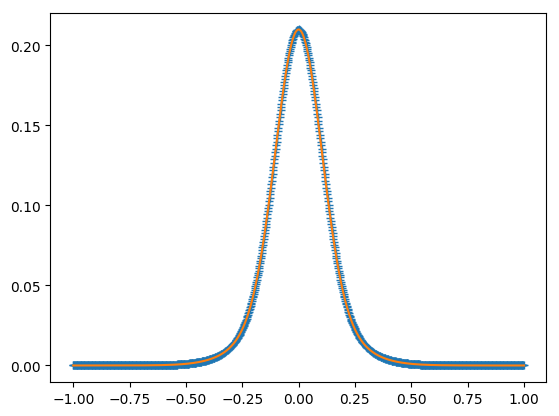

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f78af2c8d30>

In [191]:
Xres, Ures = solution_from_HH(10)
plot(Xres, Ures,"+")
plot(Xref, Uref)

In [47]:
Uref = solution_from_HH(6);
E = []
for NT = 10:5:30
    Ures = solution_from_HH(6, NT);
    err = pointwise_error(Uref, Ures)
    push!(E, err)
    println("$NT: $err")
end

10: 3.6364164144042643e-6
15: 1.595562470355083e-6
20: 8.813974900490074e-7
25: 5.508646273300055e-7
30: 3.713221438245151e-7


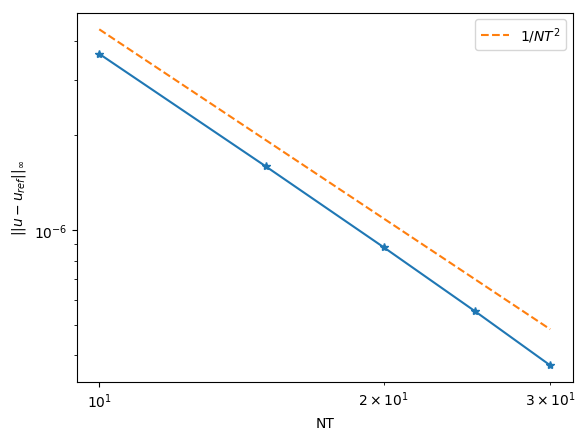

In [48]:
loglog(10:5:30, E, "*-")
r = polyfit(log.(10:5:30), log.(E), 1)
r[1] = -2.0
plot(10:5:30, exp.(r(log.(10:5:30))), "--", label=L"1/NT^2")
xlabel("NT")
ylabel(L"||u-u_{ref}||_\infty")
legend()
mpl.save("latex/figures/gauss2d_dt.tex")

In [50]:
Uref = solution_from_HH(9, 100);
E = []
for n = 5:8
    Ures = solution_from_HH(n, 100);
    err = pointwise_error(Uref[1:2^(9-n):end, 1:2^(9-n):end], Ures)
    push!(E, err)
    println("$n: $err")
end

5: 0.2379398433719898
6: 0.11245101302681038
7: 0.047875032588963196
8: 0.016038383438103376


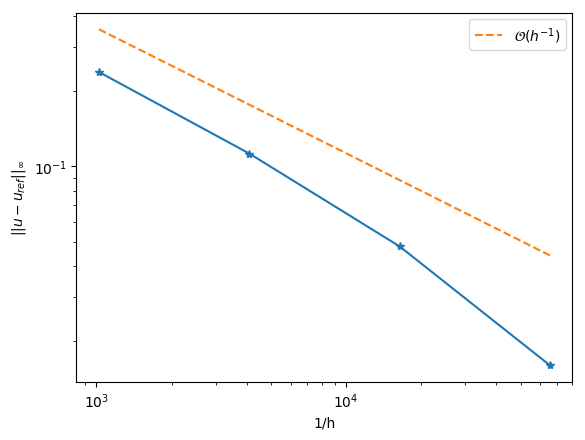

In [60]:
loglog(4 .^(5:8), E, "*-")
r = polyfit(log.(4 .^(5:8)), log.(E), 1)
r[1] = -0.5
plot(4 .^(5:8), 5e-1*exp.(r(log.(4 .^(5:8)))), "--", label=L"\mathcal{O}(h^{-1})")
xlabel("1/h")
ylabel(L"||u-u_{ref}||_\infty")
legend()
mpl.save("latex/figures/gauss2d_dx.tex")